<a href="https://colab.research.google.com/github/YMGYM/google_colab_files/blob/master/ImageEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
imgs = K.preprocessing.image.ImageDataGenerator()

In [ ]:
generator = imgs.flow_from_directory('/content/drive/MyDrive/Datasets/cafe_data', batch_size=2048)

Found 9466 images belonging to 3307 classes.


In [ ]:
x, y = generator.next()
x.shape

(2048, 256, 256, 3)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
import os
import shutil
import time

def read_all_file(path):
    output = os.listdir(path)
    file_list = []
    
    for i in output:
        if os.path.isdir(path+'/' + i):
            file_list.extend(read_all_file(path+'/' + i))
        elif os.path.isfile(path+'/'+i):
            file_list.append(path+'/'+i)
    return file_list

def copy_all_file(file_list, new_path):
    for src_path in file_list:
        file = src_path.split('/')[-1]
        path = src_path.split('/')[-2]
        
        shutil.copyfile(src_path, new_path+'/'+path+'_'+file)

start_time = time.time()

src_path="/content/drive/MyDrive/Datasets/cafe_data"
new_path='img_merge'

file_list = read_all_file(src_path)
copy_all_file(file_list, new_path)

print('='*40)
print("러닝 타임: {}".format(time.time() - start_time))

KeyboardInterrupt: ignored

# TSNE + VGG16 을 활용한 임베딩 방법

https://github.com/pitripi/tsne-grid 을 수정하여 사용했습니다.

방법론은 https://towardsdatascience.com/developing-art-style-embeddings-for-visual-similarity-comparison-of-artworks-7a9d4ade2045 을 사용했습니다.

In [ ]:
!unzip -q /content/drive/MyDrive/Datasets/cafe_images.zip  -d images/

In [ ]:
!rm /content/images/img_merge/img_.DS_Store
!rm /content/images/img_merge/북스쿡스_2.jpg

In [ ]:
!git clone https://github.com/pitripi/tsne-grid.git

Cloning into 'tsne-grid'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 2), reused 0 (delta 0), pack-reused 178
Receiving objects: 100% (187/187), 47.31 MiB | 43.92 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
!pip install lapjv==1.3.12

  Created wheel for lapjv: filename=lapjv-1.3.12-cp37-cp37m-linux_x86_64.whl size=117021 sha256=72eb734159eadd512c0e22940aa44feaf675722efb2e737aeb9a627f8c20cb62
  Stored in directory: /root/.cache/pip/wheels/6e/b9/b2/73732c58540e65a9ce7939f435edd3ecca7b2f23532eaaee77
Successfully built lapjv


In [ ]:
!python3 tsne_grid.py --dir ./images/img_merge --size 10 --res 64 

2021-05-29 02:37:30.242650: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
import numpy as np
import os, argparse
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from PIL import Image
from lapjv import lapjv
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import img_to_array


out_res = 64
out_name = 'tsne_grid.jpg'
out_dim = 97
to_plot = np.square(out_dim)
perplexity = 50
tsne_iter = 5000
in_dir = './images/img_merge'
out_dir = './'


def load_img(in_dir):
    pred_img = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f))]
    img_collection = []
    for idx, img in enumerate(pred_img):
        img = os.path.join(in_dir, img)
        print("image_load : ", idx + 1)
        img_collection.append(image.load_img(img, target_size=(out_res, out_res)))
    if (np.square(out_dim) > len(img_collection)):
        raise ValueError("Cannot fit {} images in {}x{} grid".format(len(img_collection), out_dim, out_dim))
    return img_collection

def get_activations(model, img_collection):
    activations = []
    for idx, img in enumerate(img_collection):
        if idx == to_plot:
            break;
        print("Processing image {}".format(idx+1))
        img = img.resize((224, 224), Image.ANTIALIAS)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        pred = model.predict(x)
        # pred = pred.reshape(49, 512)
        # gram = np.dot(pred, pred.T) # 그램 행렬로 변환
        # gram = gram.reshape(-1,)
        color_img = img_to_array(img.resize((10,10)))

        act = np.concatenate((pred.flatten(), color_img.flatten()))
        activations.append(act)
    return activations

def generate_tsne(activations):
    tsne = TSNE(perplexity=perplexity, n_components=2, init='random', n_iter=tsne_iter)
    X_2d = tsne.fit_transform(np.array(activations)[0:to_plot,:])
    X_2d -= X_2d.min(axis=0)
    X_2d /= X_2d.max(axis=0)
    return X_2d

def save_tsne_grid(img_collection, X_2d, out_res, out_dim):
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, out_dim), np.linspace(0, 1, out_dim))).reshape(-1, 2)
    cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())
    row_asses, col_asses, _ = lapjv(cost_matrix)
    grid_jv = grid[col_asses]
    out = np.ones((out_dim*out_res, out_dim*out_res, 3))

    for pos, img in zip(grid_jv, img_collection[0:to_plot]):
        h_range = int(np.floor(pos[0]* (out_dim - 1) * out_res))
        w_range = int(np.floor(pos[1]* (out_dim - 1) * out_res))
        out[h_range:h_range + out_res, w_range:w_range + out_res]  = image.img_to_array(img)

    im = image.array_to_img(out)
    im.save(out_dir + out_name, quality=100)

print("hello")
model = VGG16(weights='imagenet', include_top=False)
img_collection = load_img(in_dir)
activations = get_activations(model, img_collection)
print("Generating 2D representation.")
X_2d = generate_tsne(activations)
print("Generating image grid.")
save_tsne_grid(img_collection, X_2d, out_res, out_dim)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing image 4412
Processing image 4413
Processing image 4414
Processing image 4415
Processing image 4416
Processing image 4417
Processing image 4418
Processing image 4419
Processing image 4420
Processing image 4421
Processing image 4422
Processing image 4423
Processing image 4424
Processing image 4425
Processing image 4426
Processing image 4427
Processing image 4428
Processing image 4429
Processing image 4430
Processing image 4431
Processing image 4432
Processing image 4433
Processing image 4434
Processing image 4435
Processing image 4436
Processing image 4437
Processing image 4438
Processing image 4439
Processing image 4440
Processing image 4441
Processing image 4442
Processing image 4443
Processing image 4444
Processing image 4445
Processing image 4446
Processing image 4447
Processing image 4448
Processing image 4449
Processing image 4450
Processing image 4451
Processing image 4452
Processing image 4453
Processing image 4454
Processing image 4

우선 이미지 출력값을 그램 행렬로 변환 합니다.

In [ ]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Flatten

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
# top_model = Sequential()
# top_model.add(Flatten(input_shape=base_model.output_shape[1:]))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f517019d3d0>>

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image = load_img('/content/images.jpeg')
input_arr = img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = base_model.predict(input_arr)

In [ ]:
x = predictions.reshape(49, 512)
xt = x.T

gram = np.dot(x, xt)

In [ ]:
gram.shape

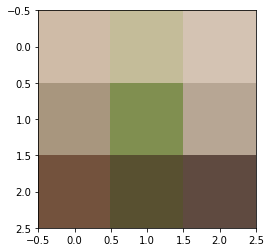

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image.resize((3,3)))
plt.show()

In [ ]:
image.resize((10,10))

In [ ]:
resized_input = img_to_array(image.resize((5,5)))

In [ ]:
resized_input.flatten().shape

(75,)

# VGG16 오버피팅 실험

신경망을 오버피팅시켜 추천이 어떻게 동작하는지 확인해 보려고 합니다.

In [ ]:
!unzip -q /content/drive/MyDrive/Datasets/cafe_image_nonMerge.zip  -d images/

unzip:  cannot find or open /content/drive/MyDrive/Datasets/cafe_image_nonMerge.zip, /content/drive/MyDrive/Datasets/cafe_image_nonMerge.zip.zip or /content/drive/MyDrive/Datasets/cafe_image_nonMerge.zip.ZIP.


In [ ]:
!rm /content/images/img/북스쿡스/2.jpg

rm: cannot remove '/content/images/img/북스쿡스/2.jpg': No such file or directory


In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
imgs = K.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
imageGenerator = imgs.flow_from_directory('/content/images/img', batch_size=64, target_size=(224,224))

Found 9465 images belonging to 3307 classes.


In [ ]:
x, y = imageGenerator.next()
x.shape

(64, 224, 224, 3)

In [ ]:
y.shape

(64, 3307)

In [ ]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Flatten

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape= (224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
base_model.trainable=False

In [ ]:
model = Sequential([
                    base_model,
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(3307, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3307)              82969323  
Total params: 97,684,011
Trainable params: 82,969,323
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.fit(imageGenerator, epochs=20)

Epoch 1/20
148/148 [==============================] - 390s 3s/step - loss: 10.4948
Epoch 2/20
148/148 [==============================] - 367s 2s/step - loss: 7.5720
Epoch 3/20
148/148 [==============================] - 370s 2s/step - loss: 6.3183
Epoch 4/20
148/148 [==============================] - 373s 3s/step - loss: 5.1827
Epoch 5/20
148/148 [==============================] - 376s 3s/step - loss: 4.2196
Epoch 6/20
148/148 [==============================] - 381s 3s/step - loss: 3.3899
Epoch 7/20
148/148 [==============================] - 378s 3s/step - loss: 2.7118
Epoch 8/20
148/148 [==============================] - 377s 3s/step - loss: 2.1095
Epoch 9/20
148/148 [==============================] - 377s 3s/step - loss: 1.6502
Epoch 10/20
148/148 [==============================] - 376s 3s/step - loss: 1.2662
Epoch 11/20
148/148 [==============================] - 379s 3s/step - loss: 0.9660
Epoch 12/20
148/148 [==============================] - 376s 3s/step - loss: 0.7209
Epoch 13/20


In [ ]:
model.save('/content/drive/MyDrive/trained_model/cafe_recommend')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/trained_model/cafe_recommend/assets


In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model = K.models.load_model('/content/drive/MyDrive/trained_model/cafe_recommend')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image = load_img('/content/img2.jpeg')
input_arr = img_to_array(image.resize((224,224)))
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

In [ ]:
predictions.argsort()[::-1][:100][:50]

array([[   0, 2198, 2199, ..., 1098, 3306, 1316]])

In [ ]:
predictions[:,1316]

array([1.], dtype=float32)

In [ ]:
imageGenerator.class_indices.values(1610)

TypeError: ignored

In [ ]:
swap = dict([(value, key) for key, value in imageGenerator.class_indices.items()])

In [ ]:
swap[1816]

'오직그대만 티앤펑 한양대점'

In [ ]:
swap[1316]

'수수원'

In [ ]:
arr[:100][::-1][1816]

# 최종 이미지로 진행하기

In [ ]:
!unzip -O cp936 -q /content/drive/MyDrive/Datasets/cafe_image_final.zip -d dataset/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
업사이드커피  뚝섬점_1.jpg:  mismatching "local" filename (鞐呾偓鞚措摐旎ろ敿  霘濎劕鞝恄1.jpg),
         continuing with "central" filename version
업사이드커피  뚝섬점_2.jpg:  mismatching "local" filename (鞐呾偓鞚措摐旎ろ敿  霘濎劕鞝恄2.jpg),
         continuing with "central" filename version
업사이드커피  뚝섬점_3.jpg:  mismatching "local" filename (鞐呾偓鞚措摐旎ろ敿  霘濎劕鞝恄3.jpg),
         continuing with "central" filename version
엉클두_1.jpg:  mismatching "local" filename (鞐夗伌霊恄1.jpg),
         continuing with "central" filename version
엉클두_2.jpg:  mismatching "local" filename (鞐夗伌霊恄2.jpg),
         continuing with "central" filename version
엉클두_3.jpg:  mismatching "local" filename (鞐夗伌霊恄3.jpg),
         continuing with "central" filename version
엉클디저트_1.jpg:  mismatching "local" filename (鞐夗伌霐旍爛韸竉1.jpg),
         continuing with "central" filename version
엉클디저트_2.jpg:  mismatching "local" filename (鞐夗伌霐旍爛韸竉2.jpg),
         continuing with "central" filename version
엉클디저트_3.jpg:  mismatching "local" filenam

In [ ]:
import pandas as pd

all_image = pd.read_csv('/content/drive/MyDrive/Datasets/cafe_image_list.csv', encoding='cp949', index_col=0)

In [ ]:
all_image

,x,Unnamed: 2,종합_제외대상,아예제외,프랜차이즈,새로이 추가,일부부적절해_수정
1.0,&meal_1.jpg,NaN,NaN,NaN,NaN,NaN,NaN
2.0,&meal_2.jpg,NaN,NaN,NaN,NaN,NaN,NaN
3.0,&meal_3.jpg,NaN,NaN,NaN,NaN,NaN,NaN
4.0,10 꼬르소꼬모 카페_1.jpg,NaN,NaN,NaN,NaN,NaN,NaN
5.0,10 꼬르소꼬모 카페_2.jpg,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9465.0,히포크라테스 스프 2호점_2.jpg,NaN,X,X,NaN,NaN,NaN
9466.0,히포크라테스 스프 2호점_3.jpg,NaN,X,X,NaN,NaN,NaN
9467.0,힘이나는커피생활 성수2호점_1.jpg,NaN,NaN,NaN,NaN,NaN,NaN
NaN,힘이나는커피생활 성수2호점_2.jpg,NaN,NaN,NaN,NaN,O,NaN


In [ ]:
import os

images = os.listdir('dataset')

len(all_image[all_image.x == '10 꼬르소꼬모 카페_2.jpg'])

1

In [ ]:
for i in images:
  data = all_image[all_image.x == i]
  
  if len(data) != 0 and (all_image[all_image.x == i ]['종합_제외대상'] == 'X').values[0]: # 종합 제외대상이면.. 
    os.remove('dataset/' + i)

In [ ]:
all_image[all_image['종합_제외대상'] == 'X']

,x,Unnamed: 2,종합_제외대상,아예제외,프랜차이즈,새로이 추가,일부부적절해_수정
120.0,BBQ 패밀리타운점_1.jpg,NaN,X,X,NaN,NaN,NaN
121.0,BBQ 패밀리타운점_2.jpg,NaN,X,X,NaN,NaN,NaN
122.0,BBQ 패밀리타운점_3.jpg,NaN,X,X,NaN,NaN,NaN
594.0,공차 롯데시네마 은평점_1.jpg,NaN,X,NaN,X,NaN,NaN
595.0,공차 롯데시네마 은평점_2.jpg,NaN,X,NaN,X,NaN,NaN
...,...,...,...,...,...,...,...
9409.0,횡성고기마을_2.jpg,NaN,X,X,NaN,NaN,NaN
9410.0,횡성고기마을_3.jpg,NaN,X,X,NaN,NaN,NaN
9464.0,히포크라테스 스프 2호점_1.jpg,NaN,X,X,NaN,NaN,NaN
9465.0,히포크라테스 스프 2호점_2.jpg,NaN,X,X,NaN,NaN,NaN


In [ ]:
len(images_removed)

8267

In [ ]:
!pip install lapjv==1.3.12

In [ ]:
!rm ./dataset/desktop.ini

In [ ]:
!rm ./dataset/수다_1.jpg
rm ./dataset/수다_2.jpg
rm ./dataset/수다_3.jpg

SyntaxError: ignored

In [ ]:
rm ./dataset/우아하게_1.jpg
rm ./dataset/우아하게_2.jpg
rm ./dataset/우아하게_3.jpg

In [ ]:
import numpy as np
import os, argparse
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from PIL import Image
from lapjv import lapjv
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import img_to_array


out_res = 64
out_name = 'tsne_grid.jpg'
out_dim = 90
to_plot = np.square(out_dim)
perplexity = 50
tsne_iter = 5000
in_dir = './dataset'
out_dir = './'


def load_img(in_dir):
    pred_img = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f))]
    img_collection = []
    for idx, img in enumerate(pred_img):
        img = os.path.join(in_dir, img)
        print("image_load : ", idx + 1, ", : ", img)
        img_collection.append(image.load_img(img, target_size=(out_res, out_res)))
    if (np.square(out_dim) > len(img_collection)):
        raise ValueError("Cannot fit {} images in {}x{} grid".format(len(img_collection), out_dim, out_dim))
    return img_collection

def get_activations(model, img_collection):
    activations = []
    for idx, img in enumerate(img_collection):
        if idx == to_plot:
            break;
        print("Processing image {}".format(idx+1))
        img = img.resize((224, 224), Image.ANTIALIAS)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        pred = model.predict(x)
        # pred = pred.reshape(49, 512)
        # gram = np.dot(pred, pred.T) # 그램 행렬로 변환
        # gram = gram.reshape(-1,)
        color_img = img_to_array(img.resize((10,10)))

        act = np.concatenate((pred.flatten(), color_img.flatten()))
        activations.append(act)
    return activations

def generate_tsne(activations):
    tsne = TSNE(perplexity=perplexity, n_components=2, init='random', n_iter=tsne_iter)
    X_2d = tsne.fit_transform(np.array(activations)[0:to_plot,:])
    X_2d -= X_2d.min(axis=0)
    X_2d /= X_2d.max(axis=0)
    return X_2d

def save_tsne_grid(img_collection, X_2d, out_res, out_dim):
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, out_dim), np.linspace(0, 1, out_dim))).reshape(-1, 2)
    cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())
    row_asses, col_asses, _ = lapjv(cost_matrix)
    grid_jv = grid[col_asses]
    out = np.ones((out_dim*out_res, out_dim*out_res, 3))

    for pos, img in zip(grid_jv, img_collection[0:to_plot]):
        h_range = int(np.floor(pos[0]* (out_dim - 1) * out_res))
        w_range = int(np.floor(pos[1]* (out_dim - 1) * out_res))
        out[h_range:h_range + out_res, w_range:w_range + out_res]  = image.img_to_array(img)

    im = image.array_to_img(out)
    im.save(out_dir + out_name, quality=100)

print("hello")
model = VGG16(weights='imagenet', include_top=False)
img_collection = load_img(in_dir)
activations = get_activations(model, img_collection)
print("Generating 2D representation.")
X_2d = generate_tsne(activations)
print("Generating image grid.")
save_tsne_grid(img_collection, X_2d, out_res, out_dim)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing image 3103
Processing image 3104
Processing image 3105
Processing image 3106
Processing image 3107
Processing image 3108
Processing image 3109
Processing image 3110
Processing image 3111
Processing image 3112
Processing image 3113
Processing image 3114
Processing image 3115
Processing image 3116
Processing image 3117
Processing image 3118
Processing image 3119
Processing image 3120
Processing image 3121
Processing image 3122
Processing image 3123
Processing image 3124
Processing image 3125
Processing image 3126
Processing image 3127
Processing image 3128
Processing image 3129
Processing image 3130
Processing image 3131
Processing image 3132
Processing image 3133
Processing image 3134
Processing image 3135
Processing image 3136
Processing image 3137
Processing image 3138
Processing image 3139
Processing image 3140
Processing image 3141
Processing image 3142
Processing image 3143
Processing image 3144
Processing image 3145
Processing image 3

In [ ]:
images = os.listdir('dataset')

In [ ]:
len(images)

8255

# activation 추출

In [ ]:
model = VGG16(weights='imagenet', include_top=False)
img_collection = load_img(in_dir)
activations = get_activations(model, img_collection)
print("Generating 2D representation.")
X_2d = generate_tsne(activations)